In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import gym
import rl_utils

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class Reinforce:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device) -> None:
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -G * log_prob
            loss.backward()
        self.optimizer.step()

c:\ProgramData\Anaconda3\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Iteration 9: 100%|██████████| 200/200 [02:19<00:00,  1.43it/s, episode=2000.0, return=196.000]


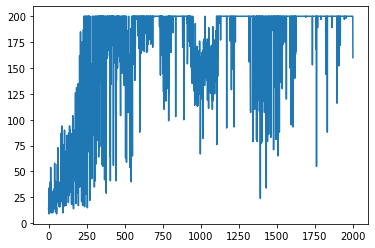

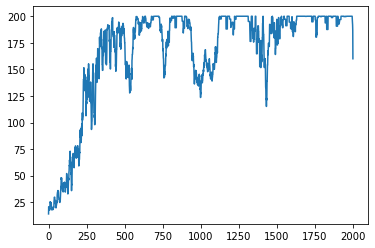

In [3]:
lr = 1e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
np.random.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = Reinforce(state_dim, hidden_dim, action_dim, lr, gamma, device)

return_list = []

@rl_utils.run_episodes(num_episodes, return_list)
def run_reinforce():
    episode_return = 0
    transition_dict = {'states': [], 'rewards': [], 'actions': [], 'next_states': [], 'dones': []}
    state = env.reset(seed=0)
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['rewards'].append(reward)
        transition_dict['next_states'].append(next_state)
        transition_dict['dones'].append(done)
        state = next_state
        episode_return += reward
    agent.update(transition_dict)
    return episode_return

run_reinforce()

episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.show()
